In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
#import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from typing import Optional, NoReturn, Any
import brownian_motion
from scipy.sparse import diags

## Some useful CIR

In [144]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class CIRParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float  # Brownian motion scale factor (standard deviation)

    def __post_init__(self) -> Optional[NoReturn]:
        #if 2 * self.a * self.b < self.c ** 2:
        #    raise ValueError("2ab has to be less than or equal to c^2.")
        return None

In [145]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_CIR_params(sigma_t: np.ndarray) -> CIRParams:
    """
    Estimate CIR params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return CIRParams(a, b, c)

## Chen

In [146]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class ChenParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    kappa: float
    nu: float
    zeta: float
    alpha: float
    mu: float
    beta: float
    eta: float

    def __post_init__(self) -> Optional[NoReturn]:
    #    if 2 * self.a * self.b < self.c ** 2:
    #        raise ValueError("2ab has to be less than or equal to c^2.")
        return None

In [147]:
def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
    if np.isnan(dsigma_t).any():
        print(dsigma_t)
        raise ValueError(
            "CIR process simulation crashed, check your CIR_params. "
            + "Maybe choose a smaller c value."
        )
    return None

def generateChenVolDrift(
    dW: np.ndarray,
    a: float,
    b: float,
    c: float,
    sigma_0: float
):
    N = len(dW)
    T = len(dW[0])
    sigma_t = np.full((N, T), sigma_0)
    for t in range(1, T):
        dsigma_t = (
            a * (b - sigma_t[:, t-1]) + c*np.sqrt(sigma_t[:,t-1])*dW[:,t]
        )
        _validate_not_nan(dsigma_t)
        sigma_t[:,t] = (sigma_t[:,t-1]+dsigma_t)
    return np.asarray(sigma_t)

def generateChenRate(
    dW: np.ndarray,
    kappa: float,
    theta: np.ndarray,
    sigma: np.ndarray
):
    N = len(dW)
    T = len(dW[0])
    rate_t = np.full((N, T), 0)
    rate_t[:, 0] = theta[:, 0]
    for t in range(1, T):
        d_rate_t = (
            kappa * (theta[:, t-1] - rate_t[:, t-1]) 
            + np.sqrt(rate_t[:,t-1])*np.sqrt(sigma[:,t-1])*dW[:,t]
        )
        rate_t[:,t] = d_rate_t + rate_t[:, t-1]
    return np.asarray(rate_t)

def getChen(
    N: int,
    T: int,
    params: ChenParams,
    random_state: Optional[int] = None
):
    rand_mat = np.random.randint(1_000_000, size=3)
    dW_1 = brownian_motion.get_dW(N, T, rand_mat[0])
    dW_2 = brownian_motion.get_dW(N, T, rand_mat[1])
    dW_3 = brownian_motion.get_dW(N, T, rand_mat[2])
    
    sigma = generateChenVolDrift(dW_3, params.mu, params.beta, params.eta, params.beta)
    theta = generateChenVolDrift(dW_2, params.nu, params.zeta, params.alpha, params.zeta)
    rate = generateChenRate(dW_1, params.kappa, theta, sigma)
    
    return rate

In [214]:
def estimateChen(rate: np.ndarray, w = 252):
    T = len(rate)
    
    if w >= T:
        raise ValueError("Window should be shorter than total time")
    
    # drift calculation vectorized: faster than pd.rolling
    roll_mat = diags(np.full(w, 1/w), np.asarray(range(0,w)), shape=(T-w+1, T)).toarray().T
    drift = rate @ roll_mat
    drift_param = estimate_CIR_params(drift)
    
    # volatility:
    vol = np.asarray(pd.DataFrame(test_proc.T).rolling(w).std()).T[:,(w-1):][0]
    vol_param = estimate_CIR_params(vol)
    
    # estimation in kappa: rolling drift/vol correspond to the value at the center of window???
    rate = rate[int(w/2)-1:-int(w/2)+1]
    rate_sqrt = np.sqrt(rate[:-1])
    y = np.diff(rate)/rate_sqrt
    x = drift/rate_sqrt - rate_sqrt
    reg = LinearRegression(fit_intercept=False)
    #print(x.reshape(-1,1))
    reg.fit(x.reshape(-1,1),y)
    kappa = reg.coef_[0]
    
    
    return ChenParams(kappa, drift_param.a, drift_param.b, drift_param.c, vol_param.a, vol_param.b, vol_param.c)

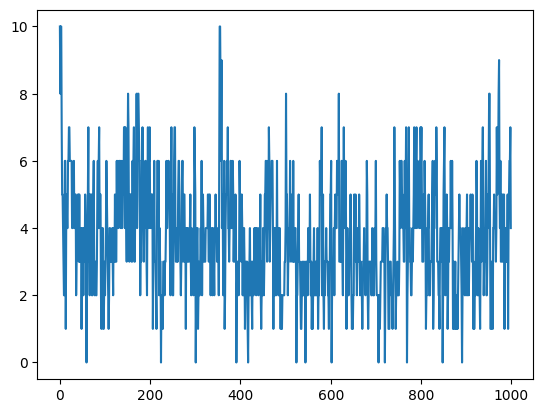

In [245]:
test_param = ChenParams(.5,.1,10,.1,.5,.5,.1)
test_proc = getChen(1,1000,test_param)[0]
plt.plot(test_proc)

In [246]:
est_param = estimateChen(test_proc)
est_param

/var/folders/2z/08m68qw50192x877gr0l5lzm0000gn/T/ipykernel_7004/64498353.py:19: RuntimeWarning: divide by zero encountered in divide
  y = np.diff(rate)/rate_sqrt
/var/folders/2z/08m68qw50192x877gr0l5lzm0000gn/T/ipykernel_7004/64498353.py:20: RuntimeWarning: divide by zero encountered in divide
  x = drift/rate_sqrt - rate_sqrt


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [126]:
estimate_CIR_params(np.asarray(pd.DataFrame(test_proc.T).rolling(252).std()).T[:,251:][0])

CIRParams(a=0.0028368766423389176, b=2.5053126765587614, c=0.006553296611683364)

In [8]:
diags([1, 2, 3], [0, 1, 2], shape=(3,5)).toarray().T

array([[1., 0., 0.],
       [2., 1., 0.],
       [3., 2., 1.],
       [0., 3., 2.],
       [0., 0., 3.]])

In [3]:
np.linspace(0, 251, 252)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [114]:
x1 = np.arange(9.0).reshape((3, 3))[1]
x2 = np.arange(3.0)

In [122]:
x2/x1

array([0.  , 0.25, 0.4 ])

In [118]:
x1

array([3., 4., 5.])

In [119]:
x2

array([0., 1., 2.])